In [1]:
import zipfile
import os

# Define paths
zip_path = "/content/dataset.zip"
extract_path = "/content/extracted_files"

# Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extracted to: {extract_path}")

Extracted to: /content/extracted_files


In [2]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Binary Classification using Handcrafted Features and ML Classifiers

In [4]:
mask_path = "/content/extracted_files/dataset/with_mask"
no_mask_path = "/content/extracted_files/dataset/without_mask"

IMG_SIZE = (64, 64)

# Function to extract HOG features
def extract_hog_features(image):
    image = cv2.resize(image, IMG_SIZE)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fd, _ = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9, visualize=True)
    return fd

# Function to extract LBP features
def extract_lbp_features(image):
    image = cv2.resize(image, IMG_SIZE)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)
    return hist

def load_dataset():
    X, y = [], []

    for img_name in os.listdir(mask_path):
        img = cv2.imread(os.path.join(mask_path, img_name))
        if img is not None:
            hog_features = extract_hog_features(img)
            lbp_features = extract_lbp_features(img)
            combined_features = np.hstack((hog_features, lbp_features))
            X.append(combined_features)
            y.append(1)

    for img_name in os.listdir(no_mask_path):
        img = cv2.imread(os.path.join(no_mask_path, img_name))
        if img is not None:
            hog_features = extract_hog_features(img)
            lbp_features = extract_lbp_features(img)
            combined_features = np.hstack((hog_features, lbp_features))
            X.append(combined_features)
            y.append(0)

    return np.array(X), np.array(y)

# Preprocessing the dataset
X, y = load_dataset()
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# SVM Classifier
svm_model = SVC(kernel='rbf', C=10, gamma='scale')
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

input_dim = X_train.shape[1]
model = SimpleNN(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the neural network with learning rate scheduling
num_epochs = 100
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate the neural network
model.eval()
with torch.no_grad():
    nn_preds = model(X_test_tensor)
    nn_preds = (nn_preds >= 0.5).float().numpy().flatten()

# Results
print("\nSVM Classifier Report:")
print(classification_report(y_test, svm_preds))
print("SVM Accuracy:", accuracy_score(y_test, svm_preds))

print("\nRandom Forest Classifier Report:")
print(classification_report(y_test, rf_preds))
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))

print("\nNeural Network Classifier Report:")
print(classification_report(y_test, nn_preds))
print("Neural Network Accuracy:", accuracy_score(y_test, nn_preds))

Epoch [10/100], Loss: 0.2733
Epoch [20/100], Loss: 0.1153
Epoch [30/100], Loss: 0.0545
Epoch [40/100], Loss: 0.0212
Epoch [50/100], Loss: 0.0117
Epoch [60/100], Loss: 0.0072
Epoch [70/100], Loss: 0.0058
Epoch [80/100], Loss: 0.0037
Epoch [90/100], Loss: 0.0035
Epoch [100/100], Loss: 0.0035

SVM Classifier Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       386
           1       0.95      0.94      0.95       433

    accuracy                           0.94       819
   macro avg       0.94      0.94      0.94       819
weighted avg       0.94      0.94      0.94       819

SVM Accuracy: 0.9426129426129426

Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       386
           1       0.90      0.96      0.93       433

    accuracy                           0.92       819
   macro avg       0.93      0.92      0.92       819
weighted avg       

# Binary Classification Using CNN

In [15]:
# Create a pytorch dataset of images
dataset_path = '/content/extracted_files/dataset'

# Calculate dataset mean and std for normalization
def calculate_mean_std(dataset_path):
    sum_mean = np.zeros(3, dtype=np.float64)
    sum_std = np.zeros(3, dtype=np.float64)
    count = 0
    class_names = ['without_mask', 'with_mask']

    print("Calculating dataset mean and std...")
    for class_name in class_names:
        class_dir = os.path.join(dataset_path, class_name)
        image_paths = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

        # Process images in batches with tqdm
        for img_path in tqdm(image_paths, desc=f"Processing {class_name}"):
            # Read image in grayscale first to check if it's valid
            if not os.path.exists(img_path):
                continue

            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (128, 128))
            img = img.astype(np.float32) / 255.0

            # Update running statistics
            img_mean = img.mean(axis=(0, 1))
            img_std = img.std(axis=(0, 1))

            sum_mean += img_mean
            sum_std += img_std
            count += 1

    mean = sum_mean / count
    std = sum_std / count

    return mean.astype(np.float32), std.astype(np.float32)

# Calculate mean and std for the dataset
mean, std = calculate_mean_std(dataset_path)
print(f"Dataset mean: {mean}")
print(f"Dataset std: {std}")

Calculating dataset mean and std...


Processing with_mask: 100%|██████████| 2165/2165 [00:13<00:00, 163.19it/s]

Dataset mean: [0.5748376  0.49752444 0.46703878]
Dataset std: [0.25625145 0.24203679 0.23397043]


In [5]:
dataset_path = '/content/extracted_files/dataset'

# Create a pytorch dataset
class FaceMaskDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = ['without_mask', 'with_mask']
        for i, class_name in enumerate(self.class_names):
            class_dir = os.path.join(self.root_dir, class_name)
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                self.images.append(image_path)  # Store path instead of loaded image
                self.labels.append(i)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = cv2.imread(image_path)
        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Resize to match training size
        image = cv2.resize(image, (128, 128))
        # Convert to tensor first
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1)  # HWC to CHW

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Create a pytorch dataloader
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.Normalize([0.5748376, 0.49752444, 0.46703878], [0.25625145, 0.24203679, 0.23397043])
])

dataset = FaceMaskDataset(dataset_path, transform=transform)

In [6]:
import os

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Determine the optimal number of workers based on available CPU cores
num_workers = os.cpu_count()

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=num_workers, pin_memory=True)

In [7]:
# Create a CNN model for face mask detection
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1,
                 padding=1, pool_type='max', pool_size=2, pool_stride=2,
                 activation='relu', batch_norm=False):
        super(ConvBlock, self).__init__()

        # Conv layer
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        # Batch normalization (optional)
        self.batch_norm = None
        if batch_norm:
            self.batch_norm = nn.BatchNorm2d(out_channels)

        # Activation function
        self.activation_type = activation
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.1)
        elif activation == 'elu':
            self.activation = nn.ELU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()

        # Pooling layer
        self.pool = None
        if pool_type == 'max':
            self.pool = nn.MaxPool2d(pool_size, pool_stride)
        elif pool_type == 'avg':
            self.pool = nn.AvgPool2d(pool_size, pool_stride)

    def forward(self, x):
        x = self.conv(x)
        if self.batch_norm:
            x = self.batch_norm(x)
        x = self.activation(x)
        if self.pool:
            x = self.pool(x)
        return x

class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=2,
                 conv_channels=[16, 32, 64], # List of channels for each conv layer
                 kernel_sizes=[3, 3, 3],     # Kernel sizes for each conv layer
                 pool_types=['max', 'max', 'max'],   # Pooling type for each layer
                 pool_sizes=[2, 2, 2],       # Pool sizes for each layer
                 activations=['relu', 'relu', 'relu'],  # Activation functions
                 use_batch_norm=False,       # Whether to use batch normalization
                 fc_sizes=[128],             # Fully connected layer sizes
                 dropout_rates=[0.5],        # Dropout rates for fc layers
                 final_pool_size=(4, 4)):    # Final adaptive pooling size

        super(CNN, self).__init__()

        # Ensure all parameter lists have the same length as conv_channels
        num_conv_layers = len(conv_channels)
        kernel_sizes = self._extend_param(kernel_sizes, num_conv_layers)
        pool_types = self._extend_param(pool_types, num_conv_layers)
        pool_sizes = self._extend_param(pool_sizes, num_conv_layers)
        activations = self._extend_param(activations, num_conv_layers)

        # Create convolutional blocks
        self.conv_blocks = nn.ModuleList()
        current_channels = in_channels

        for i in range(num_conv_layers):
            self.conv_blocks.append(
                ConvBlock(
                    in_channels=current_channels,
                    out_channels=conv_channels[i],
                    kernel_size=kernel_sizes[i],
                    pool_type=pool_types[i],
                    pool_size=pool_sizes[i],
                    activation=activations[i],
                    batch_norm=use_batch_norm
                )
            )
            current_channels = conv_channels[i]

        # Final adaptive pooling layer
        self.adaptive_pool = nn.AdaptiveAvgPool2d(final_pool_size)

        # Calculate the flattened size after conv and pooling
        self.flattened_size = conv_channels[-1] * final_pool_size[0] * final_pool_size[1]

        # Create fully connected layers
        self.fc_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        current_size = self.flattened_size
        for i, fc_size in enumerate(fc_sizes):
            self.fc_layers.append(nn.Linear(current_size, fc_size))
            self.dropout_layers.append(nn.Dropout(dropout_rates[min(i, len(dropout_rates)-1)]))
            current_size = fc_size

        # Final classification layer
        self.final_fc = nn.Linear(current_size, num_classes)

        # Save configuration for forward pass
        self.final_pool_size = final_pool_size
        self.num_conv_layers = num_conv_layers
        self.fc_sizes = fc_sizes
        self.activations = activations

    def _extend_param(self, param_list, target_length):
        """Extend parameter list to the target length by repeating the last element"""
        if len(param_list) >= target_length:
            return param_list[:target_length]
        else:
            return param_list + [param_list[-1]] * (target_length - len(param_list))

    def forward(self, x):
        # Pass through all convolutional blocks
        for block in self.conv_blocks:
            x = block(x)

        # Apply adaptive pooling
        x = self.adaptive_pool(x)

        # Flatten
        x = x.view(-1, self.flattened_size)

        # Fully connected layers with activation and dropout
        for i, (fc_layer, dropout_layer) in enumerate(zip(self.fc_layers, self.dropout_layers)):
            x = fc_layer(x)
            # Apply the same activation function as specified for the last conv layer
            if self.activations[-1] == 'relu':
                x = torch.relu(x)
            elif self.activations[-1] == 'leaky_relu':
                x = torch.nn.functional.leaky_relu(x, 0.1)
            elif self.activations[-1] == 'elu':
                x = torch.nn.functional.elu(x)
            elif self.activations[-1] == 'tanh':
                x = torch.tanh(x)
            elif self.activations[-1] == 'sigmoid':
                x = torch.sigmoid(x)
            x = dropout_layer(x)

        # Final classification layer
        x = self.final_fc(x)
        return x

In [8]:
model = CNN(
    in_channels=3,
    num_classes=2,
    conv_channels=[32, 64, 128],
    kernel_sizes=[3, 3, 3],
    pool_types=['max', 'max', 'max'],
    pool_sizes=[2, 2, 2],
    activations=['leaky_relu', 'leaky_relu', 'leaky_relu'],
    use_batch_norm=True,
    fc_sizes=[128, 64],
    dropout_rates=[0],
    final_pool_size=(4, 4)
)

In [9]:
def train_model(model, num_epochs=10, learning_rate=0.001, optimizer_type='adamw'):
    # Set up optimizer
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Training loop
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Lists to store metrics for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

            # Update progress bar
            train_accuracy = correct_train / total_train
            train_pbar.set_postfix({
                'loss': f"{train_loss/total_train*labels.size(0):.4f}",
                'acc': f"{train_accuracy:.4f}"
            })

        train_accuracy = correct_train / total_train
        avg_train_loss = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]  ")
        with torch.no_grad():
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

                # Update progress bar
                val_accuracy = correct_val / total_val
                val_pbar.set_postfix({
                    'loss': f"{val_loss/total_val*labels.size(0):.4f}",
                    'acc': f"{val_accuracy:.4f}"
                })

        val_accuracy = correct_val / total_val
        avg_val_loss = val_loss / len(val_loader)

        # Save metrics for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"Val Acc: {val_accuracy:.4f}")

    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

In [10]:
# Train the model
model, history = train_model(model, num_epochs=3, learning_rate=0.001, optimizer_type='adamw')

Epoch 1/3 [Val]  : 100%|██████████| 7/7 [00:30<00:00,  4.33s/it, loss=0.1125, acc=0.9035]


Epoch 1/3, Train Loss: 0.3658, Train Acc: 0.8480, Val Loss: 0.2582, Val Acc: 0.9035


Epoch 2/3 [Val]  : 100%|██████████| 7/7 [00:28<00:00,  4.14s/it, loss=0.1018, acc=0.8974]


Epoch 2/3, Train Loss: 0.2216, Train Acc: 0.9154, Val Loss: 0.2336, Val Acc: 0.8974


Epoch 3/3 [Val]  : 100%|██████████| 7/7 [00:31<00:00,  4.43s/it, loss=0.0716, acc=0.9280]

Epoch 3/3, Train Loss: 0.1797, Train Acc: 0.9356, Val Loss: 0.1643, Val Acc: 0.9280


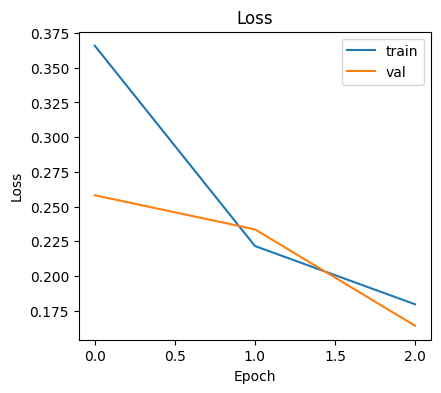

In [11]:
# Plot the losses
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(history['train_losses'], label='train')
plt.plot(history['val_losses'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

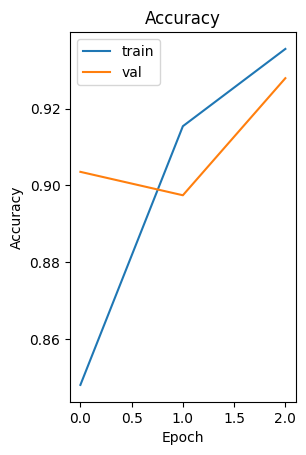

In [12]:
# Plot accuracy
plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(history['train_accuracies'], label='train')
plt.plot(history['val_accuracies'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()